In [2]:
import scanpy as sc
import numpy as np
import warnings 
warnings.filterwarnings ("ignore")
import re, random
from pathlib import Path
import json
import pandas as pd
from pandas import DataFrame
import os, sys
import torch
import TOSICA
from icecream import ic
ic.configureOutput(includeContext=True, argToStringFunction=lambda _: str(_))
from utils.log_util import logger

root_data_dir = Path('data')
data_type = 'hPancreas'
data_dir = root_data_dir / data_type

Information of GPU

In [3]:
print(torch.cuda.get_device_capability(device=None))
print(torch.cuda.get_device_name(device=None))

(7, 5)
Tesla T4


Reference data

In [5]:
train_file = data_dir / 'train.h5ad'
ref_adata = sc.read(train_file)
gene_names = set(ref_adata.var_names)
logger.info(len(gene_names))
logger.info(ref_adata.var_names[:5])
logger.info(ref_adata.obs_names[:5])
# view of the data
ref_adata = ref_adata[:, ref_adata.var_names]
logger.info(ref_adata)
logger.info(ref_adata.obs.Celltype.value_counts())

a = ref_adata[['human1_lib1.final_cell_0001', 'human1_lib1.final_cell_0003'], ['COL1A1', 'COL1A2', 'PPY', 'CTRB1']]
logger.info(a)
b = a.X.toarray().tolist()
logger.info(b)

23-05-17 07:34 attrs.py 77: Creating converter from 3 to 5
23-05-17 07:34 635996934.py 4: 3000
23-05-17 07:34 635996934.py 5: Index(['COL1A1', 'COL1A2', 'PPY', 'CTRB1', 'CELA3A'], dtype='object')
23-05-17 07:34 635996934.py 6: Index(['human1_lib1.final_cell_0001', 'human1_lib1.final_cell_0003',
       'human1_lib1.final_cell_0004', 'human1_lib1.final_cell_0005',
       'human1_lib1.final_cell_0006'],
      dtype='object')
23-05-17 07:34 635996934.py 9: View of AnnData object with n_obs × n_vars = 10600 × 3000
    obs: 'Celltype'
    var: 'Gene Symbol'
23-05-17 07:34 635996934.py 10: Celltype
alpha          3136
beta           2966
ductal         1290
acinar         1144
delta           793
PSC             524
PP              356
endothelial     273
macrophage       52
mast             25
epsilon          21
schwann          13
t_cell            7
Name: count, dtype: int64
23-05-17 07:34 635996934.py 13: View of AnnData object with n_obs × n_vars = 2 × 4
    obs: 'Celltype'
    var: 'Ge

Query data

In [6]:
query_adata = sc.read(data_dir / 'test.h5ad')
logger.info('%s', query_adata.var_names)
query_adata = query_adata[:, query_adata.var_names]
logger.info(query_adata)
logger.info('query_adata.obs.Celltype\n%s', query_adata.obs.Celltype)
logger.info('query_adata.var\n%s', query_adata.var)
logger.info(query_adata.obs.Celltype.value_counts())
logger.info(query_adata.shape)
# type(query_adata.var['Gene Symbol'])) is Series

23-05-17 07:35 405375039.py 2: Index(['COL1A1', 'COL1A2', 'PPY', 'CTRB1', 'CELA3A', 'CTRB2', 'SPINK1',
       'COL3A1', 'CPB1', 'COL6A3',
       ...
       'DUSP19', 'ZNF160', 'NPRL2', 'CILP2', 'SNED1', 'FAM110D', 'SELL',
       'C9orf135', 'GRIN2D', 'HERC5'],
      dtype='object', length=3000)
23-05-17 07:35 405375039.py 4: View of AnnData object with n_obs × n_vars = 4218 × 3000
    obs: 'Celltype'
    var: 'Gene Symbol'
23-05-17 07:35 405375039.py 5: query_adata.obs.Celltype
10th_C11_S96    beta
10th_C13_S61    beta
10th_C14_S53    beta
10th_C17_S97    beta
10th_C19_S62     PSC
                ... 
Sample_1594       PP
Sample_1595       PP
Sample_1597       PP
Sample_1598       PP
Sample_1600       PP
Name: Celltype, Length: 4218, dtype: category
Categories (11, object): ['MHC class II', 'PP', 'PSC', 'acinar', ..., 'ductal', 'endothelial', 'epsilon', 'mast']
23-05-17 07:35 405375039.py 6: query_adata.var
         Gene Symbol
COL1A1        COL1A1
COL1A2        COL1A2
PPY             

Training:

Prediction

In [7]:
from app.app_utils import read_train_config

data_type = 'hPancreas'
project_dir = Path(f'projects/hGOBP_demo')

model_weight_paths = read_train_config(data_type)
model_weight_path = model_weight_paths[0]
new_adata = TOSICA.pre(query_adata, model_weight_path=model_weight_path, project_path=project_dir)

23-05-17 07:35 app_utils.py 12: data_type hPancreas
23-05-17 07:35 pre.py 46: cuda:0
23-05-17 07:35 pre.py 88: all_line num 4218
23-05-17 07:35 pre.py 97: start_line_i num 0


the X data in predicted new_adata is the attention weight, thats 4218 * 299, the 299 pathways has most genes.

In [8]:
new_adata.write('demo_attn.h5ad')
new_adata

... storing 'Prediction' as categorical
... storing 'Celltype' as categorical
23-05-17 07:35 attrs.py 203: Creating converter from 5 to 3


AnnData object with n_obs × n_vars = 4218 × 299
    obs: 'Prediction', 'Probability', 'Celltype'

In [9]:
new_adata.raw = new_adata
sc.pp.normalize_total(new_adata, target_sum=1e4)
sc.pp.log1p(new_adata)
sc.pp.scale(new_adata, max_value=10)
sc.tl.pca(new_adata, svd_solver='arpack')
sc.pp.neighbors(new_adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(new_adata)

23-05-17 07:35 byteflow.py 74: bytecode dump:
>          0	NOP(arg=None, lineno=53)
           2	LOAD_FAST(arg=0, lineno=53)
           4	LOAD_CONST(arg=1, lineno=53)
           6	BINARY_SUBSCR(arg=None, lineno=53)
           8	LOAD_CONST(arg=2, lineno=53)
          10	BINARY_AND(arg=None, lineno=53)
          12	LOAD_CONST(arg=3, lineno=53)
          14	BINARY_LSHIFT(arg=None, lineno=53)
          16	LOAD_CONST(arg=4, lineno=53)
          18	BINARY_AND(arg=None, lineno=53)
          20	LOAD_FAST(arg=0, lineno=54)
          22	LOAD_CONST(arg=1, lineno=54)
          24	BINARY_SUBSCR(arg=None, lineno=54)
          26	LOAD_CONST(arg=5, lineno=54)
          28	BINARY_LSHIFT(arg=None, lineno=54)
          30	LOAD_CONST(arg=4, lineno=54)
          32	BINARY_AND(arg=None, lineno=54)
          34	LOAD_FAST(arg=0, lineno=54)
          36	LOAD_CONST(arg=1, lineno=54)
          38	BINARY_SUBSCR(arg=None, lineno=54)
          40	BINARY_XOR(arg=None, lineno=54)
          42	LOAD_CONST(arg=6, lineno

In [3]:
col = np.array([
"#98DF8A","#E41A1C" ,"#377EB8", "#4DAF4A" ,"#984EA3" ,"#FF7F00" ,"#FFFF33" ,"#A65628" ,"#F781BF" ,"#999999","#1F77B4","#FF7F0E","#279E68","#FF9896"
]).astype('<U7')

celltype = ("alpha","beta","ductal","acinar","delta","PP","PSC","endothelial","epsilon","mast","macrophage","schwann",'t_cell')
new_adata.obs['Prediction'] = new_adata.obs['Prediction'].astype('category')
new_adata.obs['Prediction'] = new_adata.obs['Prediction'].cat.reorder_categories(list(celltype))
new_adata.uns['Prediction_colors'] = col[1:]

celltype = ("MHC class II","alpha","beta","ductal","acinar","delta","PP","PSC","endothelial","epsilon","mast")
new_adata.obs['Celltype'] = new_adata.obs['Celltype'].astype('category')
new_adata.obs['Celltype'] = new_adata.obs['Celltype'].cat.reorder_categories(list(celltype))
new_adata.uns['Celltype_colors'] = col[:11]

NameError: name 'new_adata' is not defined

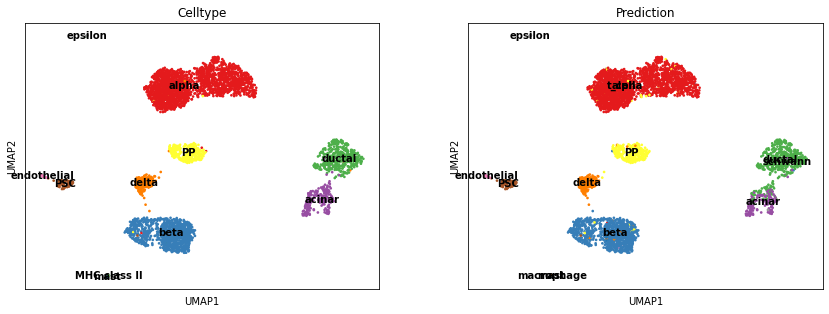

In [10]:
sc.pl.umap(new_adata, color=['Celltype', 'Prediction'],legend_loc='on data')

Training on pre-weights of 'human_gobp' mask:

In [11]:
!cp ./hGOBP_demo/model-0.pth ./pre_weights.pth

In [12]:
TOSICA.train(ref_adata, gmt_path='human_gobp', label_name='Celltype',pre_weights='pre_weights.pth',epochs=1)

cuda:0
Mask loaded!
<All keys matched successfully>
Model builded!


[valid epoch 0] loss: 0.040, acc: 0.992: 100%|██████████| 5096/5096 [00:31<00:00, 162.61it/s]


Training finished!
